### CS5228 Mini Project Team 07 - Unsupervised Learning

#### Objective

This notebook aims to apply K-Means and DBSCAN clustering algorithms to group customers in the training dataset based on usage patterns.

#### Imports

In [68]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

#### Read the processed dataset

In [69]:
with open('./dataset/cleaned_datasets.pkl', 'rb') as f:
    dataests = pickle.load(f)
    
min_max_train_df = dataests['min_max_scale_pca']['train']
standard_train_df = dataests['standard_scale_pca']['train']

# Remove the Churn column
min_max_train_df = min_max_train_df.drop(columns=['Churn'])
standard_train_df = standard_train_df.drop(columns=['Churn'])

In [70]:
min_max_train_df.head(3)

,State_freq,State_label,Account length,International plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes
0,0.019505,0,0.524793,0,0.50,0.755701,0.68750,0.542755,0.582353,0.572161,0.436090,0.500
1,0.024756,1,0.438017,0,0.52,0.460661,0.76875,0.537531,0.605882,0.599772,0.526316,0.685
2,0.018755,2,0.561983,0,0.00,0.693843,0.71250,0.333242,0.647059,0.338457,0.533835,0.610


In [71]:
standard_train_df.head(3)

,State_freq,State_label,Account length,International plan,Number vmail messages,Total day minutes,Total day calls,Total eve minutes,Total eve calls,Total night minutes,Total night calls,Total intl minutes
0,0.019505,0,0.692163,0,1.247508,1.579670,0.484868,-0.058619,-0.050781,0.857403,-0.469031,-0.085020
1,0.024756,1,0.161278,0,1.320985,-0.329918,1.135375,-0.095916,0.147654,1.048458,0.149054,1.242179
2,0.018755,2,0.919686,0,-0.589414,1.179302,0.685024,-1.554439,0.494917,-0.759668,0.200561,0.704125


Determine the optimal number of clusters using the Elbow Method or Silhouette Score

In [72]:
def kmeans_elbow_method(data, start, step, num_steps=10, **params):
    mse_scores = []
    for i in np.arange(start, start + num_steps * step, step):
        params['n_clusters'] = i
        model = KMeans(**params)
        model.fit(data)
        mse_scores.append(model.inertia_)
    return mse_scores

def kmeans_silhouette_scores(data, start, step, num_steps=10, **params):
    silhouette_scores = []
    for i in np.arange(start, start + num_steps * step, step):
        params['n_clusters'] = i
        model = KMeans(**params)
        model.fit(data)
        silhouette_scores.append(silhouette_score(data, model.labels_, random_state=42))
    return silhouette_scores

def plot_results(results_dict, metric_name, num_steps=10):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    for i, (scale_type, values) in enumerate(results_dict.items()):
        x_values = np.arange(values['start'], values['start'] + num_steps * values['step'], values['step'])
        ax[i].plot(x_values, values['results'], marker='o')
        ax[i].set_title(f'{scale_type} Scaled Data ({metric_name})')
        ax[i].set_xlabel('Number of Clusters' if 'KMeans' in metric_name else 'Epsilon (eps)')
        ax[i].set_ylabel(metric_name)
        ax[i].grid(True)
    
    plt.tight_layout()
    plt.show()



#### K-means

The elbow is at around k=4 based on MSE

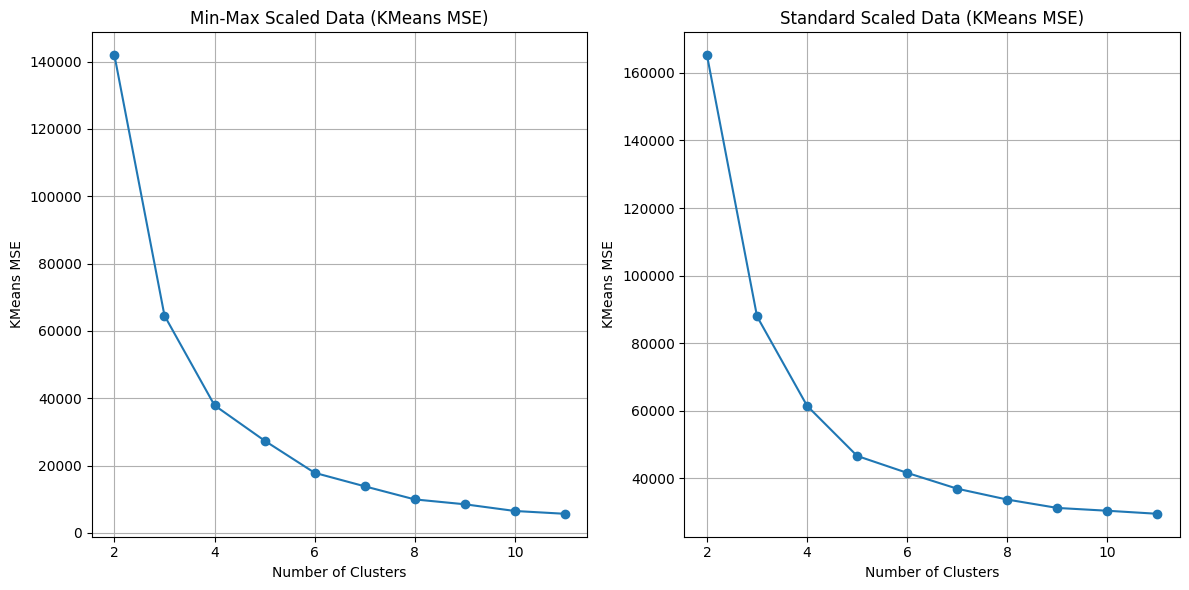

In [73]:
scaling_params = {
    'Min-Max': {'start': 2, 'step': 1},
    'Standard': {'start': 2, 'step': 1}
}

scaling_params['Min-Max']['results'] = kmeans_elbow_method(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], n_init='auto', init='k-means++', random_state=42)
scaling_params['Standard']['results'] = kmeans_elbow_method(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], n_init='auto', init='k-means++', random_state=42)
plot_results(scaling_params, metric_name='KMeans MSE')

There is no clear peak for silhouette_score and we prefer values that are closer to 1. so k=2,3,4 may be better choices

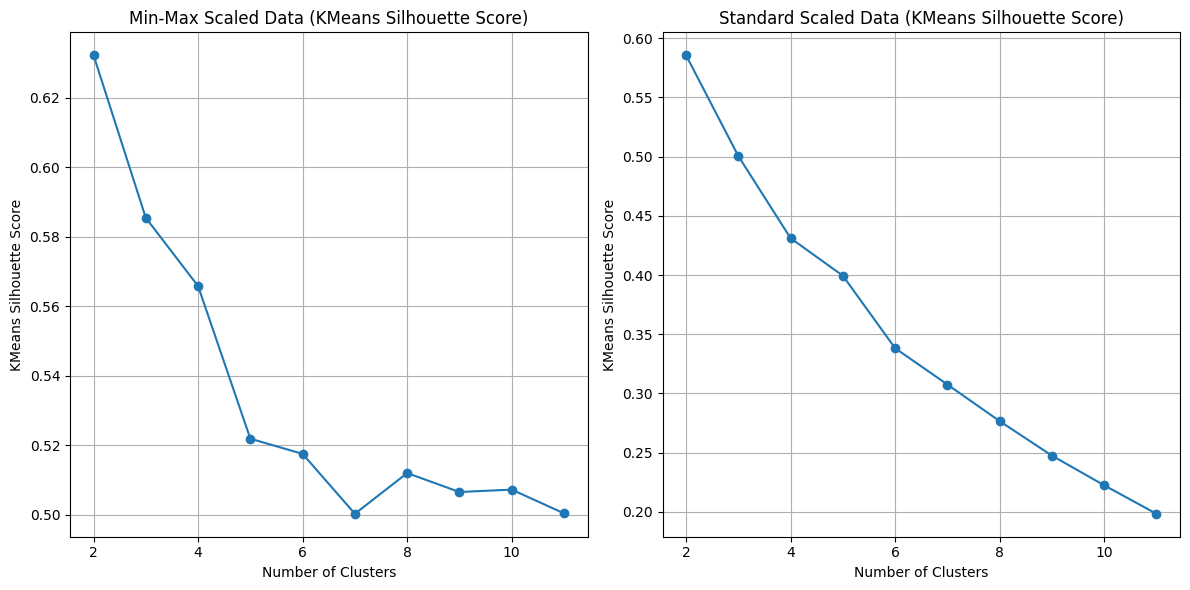

In [74]:
scaling_params = {
    'Min-Max': {'start': 2, 'step': 1},
    'Standard': {'start': 2, 'step': 1}
}

scaling_params['Min-Max']['results'] = kmeans_silhouette_scores(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], n_init='auto', init='k-means++', random_state=42)
scaling_params['Standard']['results'] = kmeans_silhouette_scores(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], n_init='auto', init='k-means++', random_state=42)
plot_results(scaling_params, metric_name='KMeans Silhouette Score')

#### DBSCAN

In [75]:
def dbscan_silhouette_scores(data, start, step, num_steps=10, **params):
    silhouette_scores = []
    # print(np.arange(start, start + num_steps * step, step))
    for eps in np.arange(start, start + num_steps * step, step):
        params['eps'] = eps
        model = DBSCAN(**params)
        model.fit(data)

        # Compute silhouette score only if there are at least 2 clusters
        if len(set(model.labels_)) > 1:
            silhouette_scores.append(silhouette_score(data, model.labels_))
        else:
            silhouette_scores.append(-1)  # Avoid errors for single clusters
    return silhouette_scores

[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -0.019046722270484644, -0.01745956303592789, -0.01745956303592789, -0.013503866790007908, -0.011128544042611974, -0.010340143743278718, -0.008770869754353011, -0.008770869754353011, -0.008770869754353011, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007207459860941726, -0.006425455414119059, -0.43702212784556554, -0.578039631058093, -0.5637862738000686, -0.5895628658997818, -0.5824312838031905, -0.5785055159807918, -0.5495503506786764, -0.5161944226337865, -0.4799135600907162, -0.46472831322956953, -0.4442319996065484, -0.43894399029818437, -0.42358785851448577, -0.3789480266355604, -0.377133877111946, -0.35530813256106164, -0.30925878294944453, -0.30693298379375183, -0.30578482887267083, -0.2855070055519028, -0.2855070055519028, -0.28487067514642217, -0.2

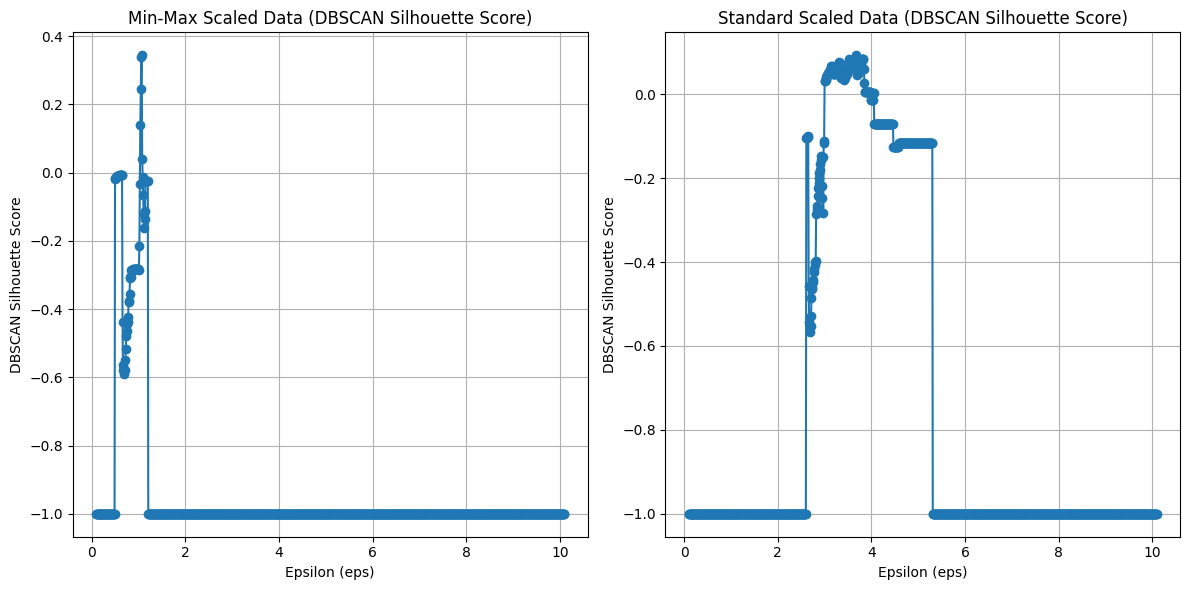

In [ ]:
scaling_params = {
    'Min-Max': {'start': 0.1, 'step': 0.01},
    'Standard': {'start': 0.1, 'step': 0.01}
}

num_steps = 1000

scaling_params['Min-Max']['results'] = dbscan_silhouette_scores(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], num_steps=num_steps, min_samples=50)
scaling_params['Standard']['results'] = dbscan_silhouette_scores(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], num_steps=num_steps, min_samples=50)

print(scaling_params['Min-Max']['results'], scaling_params['Standard']['results'])
plot_results(scaling_params, metric_name='DBSCAN Silhouette Score', num_steps=num_steps)

Now we narrow the search range and reduce step size

[-0.019046722270484644, -0.01745956303592789, -0.01745956303592789, -0.013503866790007908, -0.011128544042611974, -0.010340143743278718, -0.008770869754353011, -0.008770869754353011, -0.008770869754353011, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007207459860941726, -0.006425455414119059, -0.43702212784556554, -0.578039631058093, -0.5637862738000686, -0.5895628658997818, -0.5824312838031905, -0.5785055159807918, -0.5495503506786764, -0.5161944226337865, -0.4799135600907162, -0.46472831322956953, -0.4442319996065484, -0.43894399029818437, -0.42358785851448577, -0.3789480266355604, -0.377133877111946, -0.35530813256106164, -0.30925878294944453, -0.30693298379375183, -0.30578482887267083, -0.2855070055519028, -0.2855070055519028, -0.28487067514642217, -0.28487067514642217, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975

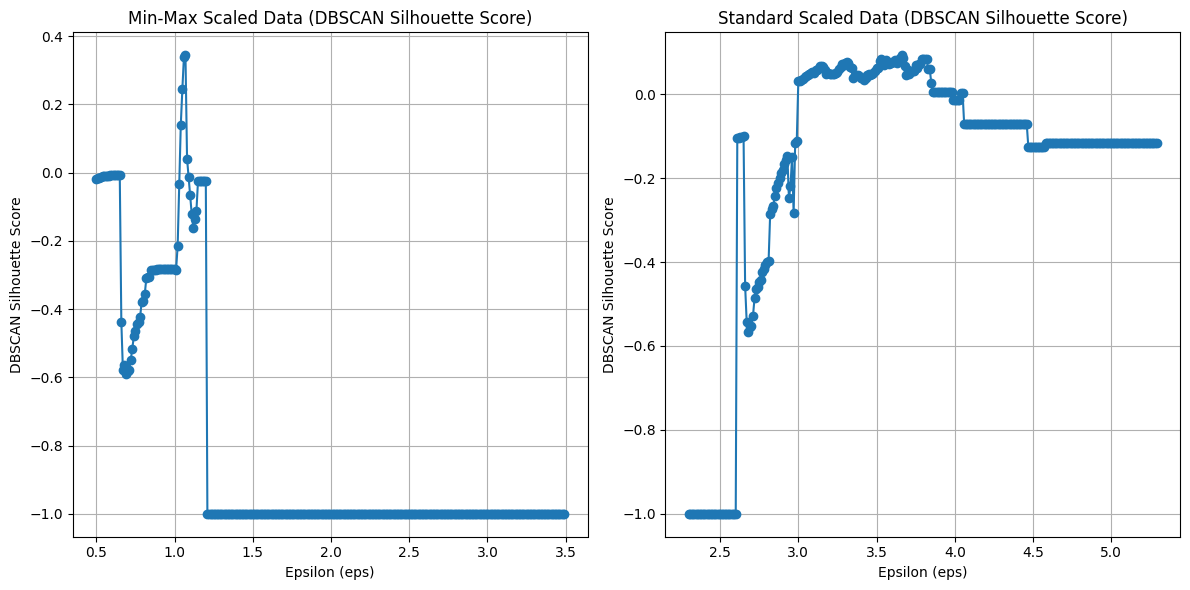

In [96]:
scaling_params = {
    'Min-Max': {'start': 0.5, 'step': 0.01},
    'Standard': {'start': 2.3, 'step': 0.01}
}

num_steps = 300

scaling_params['Min-Max']['results'] = dbscan_silhouette_scores(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], num_steps=num_steps, min_samples=50)
scaling_params['Standard']['results'] = dbscan_silhouette_scores(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], num_steps=num_steps, min_samples=50)

print(scaling_params['Min-Max']['results'], scaling_params['Standard']['results'])
plot_results(scaling_params, metric_name='DBSCAN Silhouette Score', num_steps=num_steps)

[-0.019046722270484644, -0.018252637796306134, -0.01745956303592789, -0.01745956303592789, -0.01745956303592789, -0.013503866790007908, -0.013503866790007908, -0.012713791121537634, -0.011128544042611974, -0.011128544042611974, -0.010340143743278718, -0.009557086729603653, -0.008770869754353011, -0.008770869754353011, -0.008770869754353011, -0.008770869754353011, -0.008770869754353011, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007988001064420788, -0.007207459860941726, -0.007207459860941726, -0.006425455414119059, -0.0017174544300988808, -0.43702212784556554, -0.43182907841320406, -0.578039631058093, -0.5759596771729595, -0.5637862738000686, -0.561812099265682, -0.5895628658997818, -0.5831019288839919, -0.5824312838031905, -0.5804652719861086, -0.5785055159807918, -0.5558429855461496, -0.5495503506

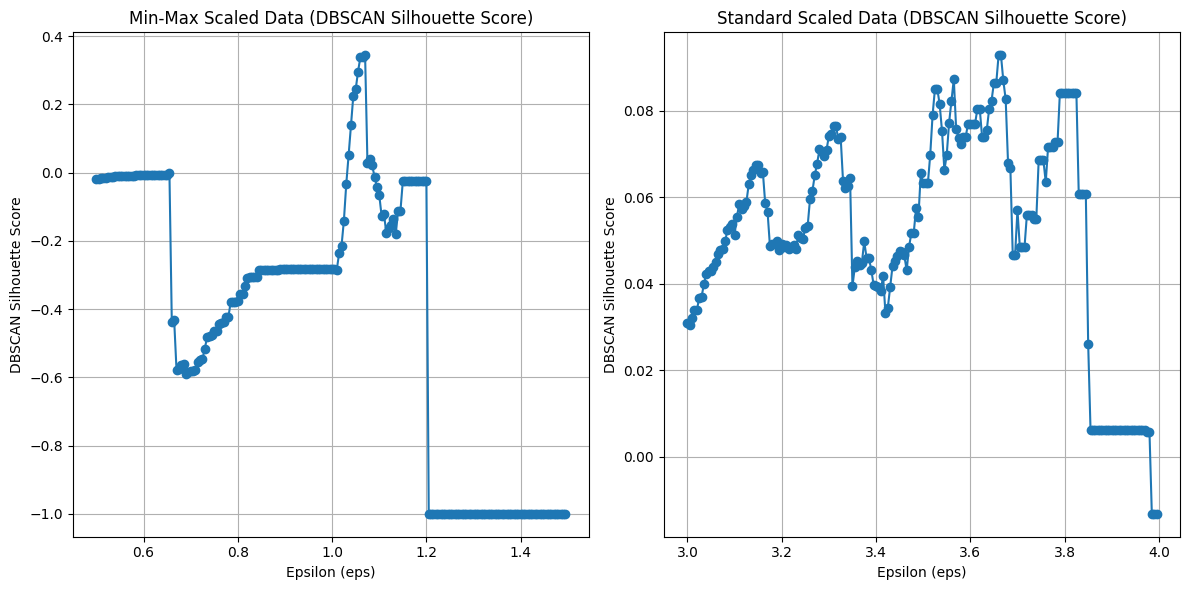

In [97]:
scaling_params = {
    'Min-Max': {'start': 0.5, 'step': 0.005},
    'Standard': {'start': 3, 'step': 0.005}
}

num_steps = 200

scaling_params['Min-Max']['results'] = dbscan_silhouette_scores(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], num_steps=num_steps, min_samples=50)
scaling_params['Standard']['results'] = dbscan_silhouette_scores(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], num_steps=num_steps, min_samples=50)

print(scaling_params['Min-Max']['results'], scaling_params['Standard']['results'])
plot_results(scaling_params, metric_name='DBSCAN Silhouette Score', num_steps=num_steps)

[-0.377133877111946, -0.3560271352850066, -0.35530813256106164, -0.33241212052664615, -0.30925878294944453, -0.3073650514941439, -0.30693298379375183, -0.30578482887267083, -0.30578482887267083, -0.2855070055519028, -0.2855070055519028, -0.2855070055519028, -0.2855070055519028, -0.28487067514642217, -0.28487067514642217, -0.28487067514642217, -0.28487067514642217, -0.2844828431023203, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2840449519975977, -0.2842015357383509, -0.23528950273976892, -0.21494045939182096, -0.14095358924687224, -0.034609739816551646

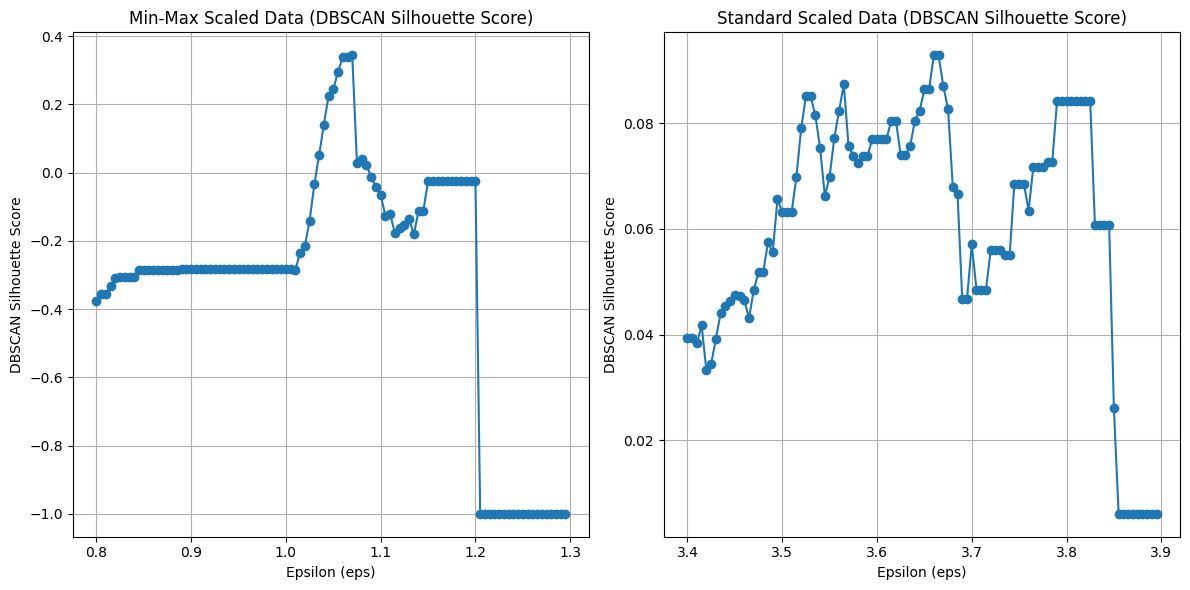

In [98]:
scaling_params = {
    'Min-Max': {'start': 0.8, 'step': 0.005},
    'Standard': {'start': 3.4, 'step': 0.005}
}

num_steps = 100

scaling_params['Min-Max']['results'] = dbscan_silhouette_scores(min_max_train_df, start=scaling_params['Min-Max']['start'], step=scaling_params['Min-Max']['step'], num_steps=num_steps, min_samples=50)
scaling_params['Standard']['results'] = dbscan_silhouette_scores(standard_train_df, start=scaling_params['Standard']['start'], step=scaling_params['Standard']['step'], num_steps=num_steps, min_samples=50)

print(scaling_params['Min-Max']['results'], scaling_params['Standard']['results'])
plot_results(scaling_params, metric_name='DBSCAN Silhouette Score', num_steps=num_steps)

eps = 1.05 for minmax and 3.68 for standard